## Setup

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso


## EDA

In [50]:
df = pd.read_csv('../data/tod-on-main.csv')

In [51]:
df = df.dropna(subset=['n_movers_out_Lowincome'])

In [52]:
before_df = df.filter(regex=r'^(Before)', axis=1)
# before_df = before_df.drop(["Before 4 bedrooms", "Before 5 or more bedrooms", 'Before No bedrooms', 'Before 1 bedroom', "Before Apartment"], axis=1)

In [53]:
after_df = df.filter(regex=r'^(After)', axis=1)
# after_df = after_df.drop(['After No bedrooms', 'After 1 bedroom', 'After Other attached dwelling'], axis=1)

In [54]:
def calculating_average_bedrooms(df, before = True):
    word = "Before" if before else "After"
    null_rows = df[df[f"{word} Average number of bedrooms per dwelling"].isnull()]
    weighted_sum = (0.5 * null_rows[f"{word} 0 to 1 bedroom"] + 2 * null_rows[f"{word} 2 bedrooms"] + 3 * null_rows[f"{word} 3 bedrooms"] + 4.5 * null_rows[f"{word} 4 or more bedrooms"])
    total = (null_rows[[f"{word} 0 to 1 bedroom", f"{word} 2 bedrooms", f"{word} 3 bedrooms", f"{word} 4 or more bedrooms"]].sum(axis=1))
    null_rows[f"{word} Average number of bedrooms per dwelling"] = weighted_sum / total
    df.loc[null_rows.index, f"{word} Average number of bedrooms per dwelling"] = null_rows[f"{word} Average number of bedrooms per dwelling"]

In [55]:
calculating_average_bedrooms(before_df)
calculating_average_bedrooms(after_df, False)

/var/folders/qd/w0jg42cx76sc6s81d9zfb7t80000gn/T/ipykernel_22136/1411688805.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_rows[f"{word} Average number of bedrooms per dwelling"] = weighted_sum / total
/var/folders/qd/w0jg42cx76sc6s81d9zfb7t80000gn/T/ipykernel_22136/1411688805.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[null_rows.index, f"{word} Average number of bedrooms per dwelling"] = null_rows[f"{word} Average number of bedrooms per dwelling"]
/var/folders/qd/w0jg42cx76sc6s81d9zfb7t80000gn/T/ipykernel_22136/1411688805.py:6: SettingWi

In [56]:
cols_to_drop = before_df.filter(regex='bedrooms?$', axis=1).columns
before_df = before_df.drop(columns = cols_to_drop)
cols_to_drop = after_df.filter(regex='bedrooms?$', axis=1).columns
after_df = after_df.drop(columns = cols_to_drop)

In [57]:
# Remove other dwelling and other single-attached (co-linearity) 
# & remove apartment (remove bedrooms, maybe add it back again later)

In [58]:
# Do we maybe even remove Dwellings since there is collinearity?

In [59]:
before_df = before_df.drop(["Before Apartment", "Before Other dwelling", "Before Other single-attached house"], axis=1)
after_df = after_df.drop(["After Other dwelling", "After Other attached dwelling", "After Other single-attached house"], axis=1)

In [60]:
before_df.columns, before_df.shape

(Index(['Before Population Density per square kilometre', 'Before Dwellings',
        'Before Total Occupied Private Dwellings',
        'Before Single-detached house', 'Before Semi-detached house',
        'Before Row house', 'Before Apartment, duplex',
        'Before Apartment, building that has fewer than five storeys',
        'Before Apartment, building that has five or more storeys',
        'Before Movable dwelling',
        'Before Average number of bedrooms per dwelling', 'Before Owned',
        'Before Rented'],
       dtype='object'),
 (68, 13))

In [61]:
after_df.columns, after_df.shape

(Index(['After Population Density per square kilometre', 'After Dwellings',
        'After Total Occupied Private Dwellings', 'After Single-detached house',
        'After Semi-detached house', 'After Row house',
        'After Apartment, duplex',
        'After Apartment, building that has fewer than five storeys',
        'After Apartment, building that has five or more storeys',
        'After Movable dwelling',
        'After Average number of bedrooms per dwelling', 'After Owned',
        'After Rented'],
       dtype='object'),
 (68, 13))

## Looking at Correlation

In [62]:
b_corr = before_df.corr()
a_corr = after_df.corr()

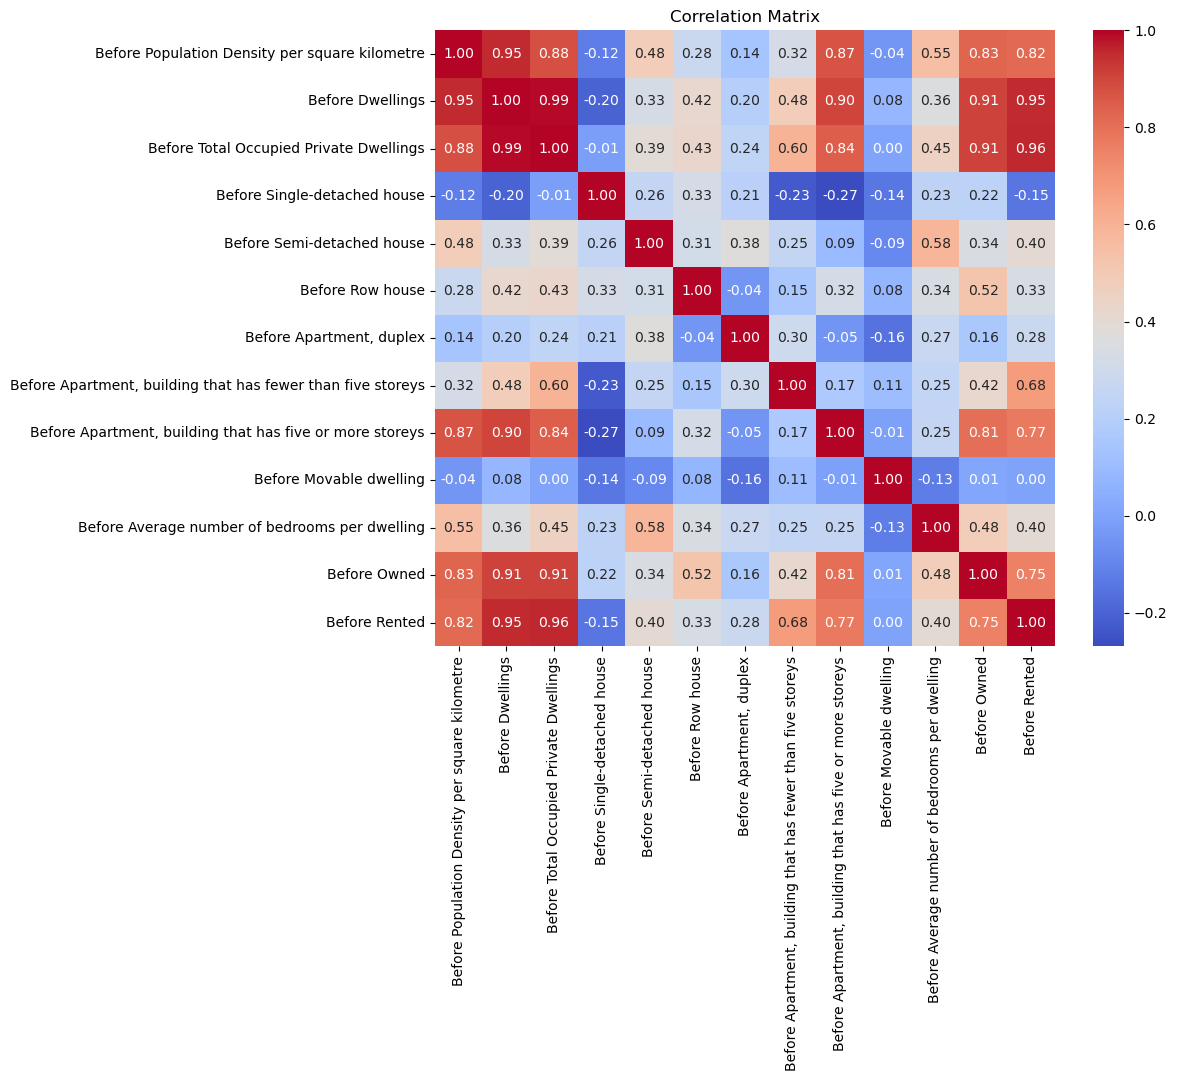

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(b_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

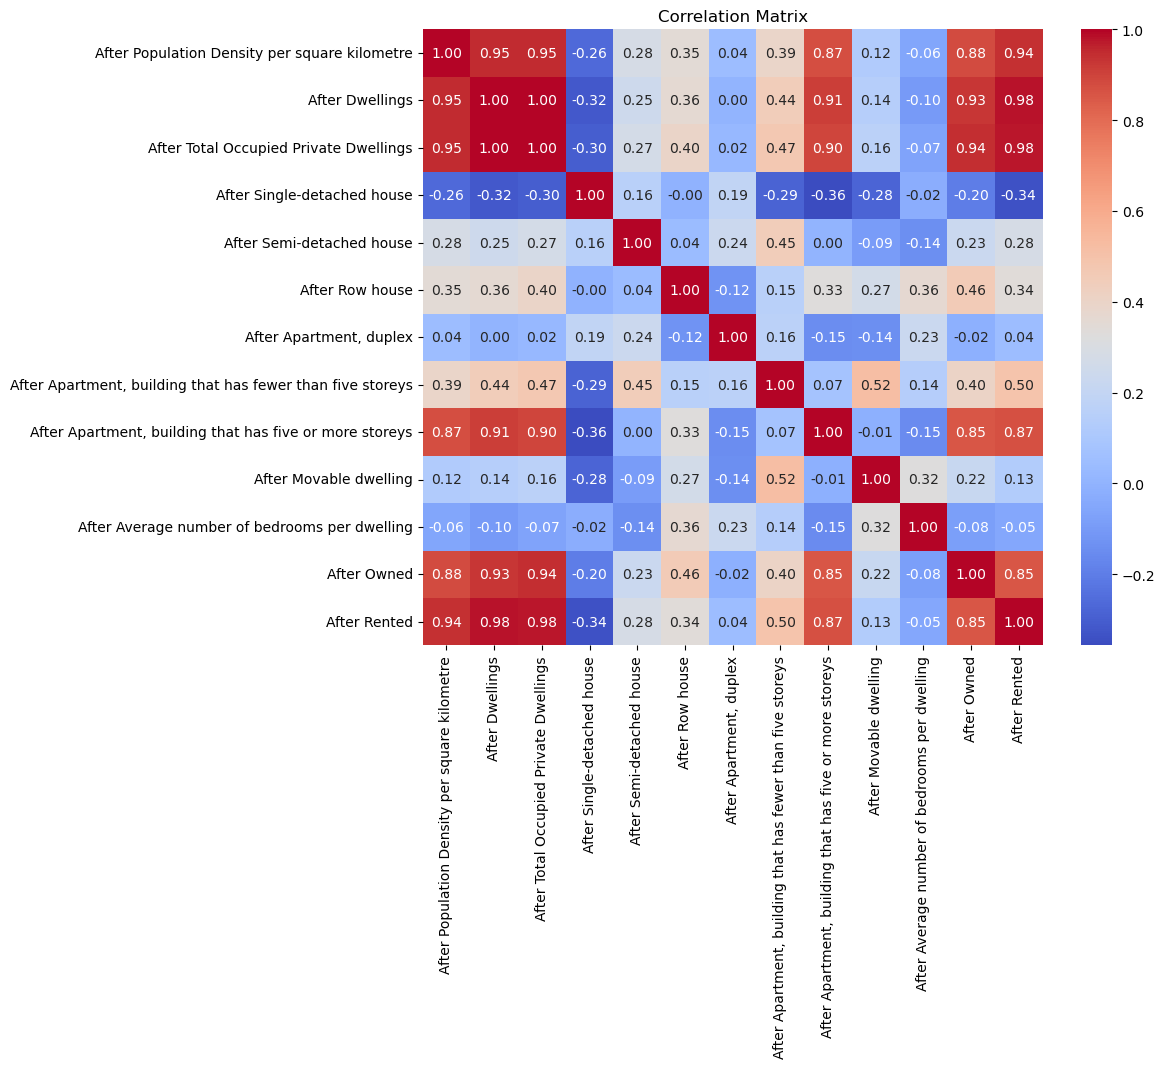

In [64]:
plt.figure(figsize=(10, 8))
sns.heatmap(a_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Missing Values

In [77]:
after_df.isnull().sum().sort_values(ascending=False)

After Semi-detached house                                     1
After Row house                                               1
After Apartment, duplex                                       1
After Apartment, building that has fewer than five storeys    1
After Average number of bedrooms per dwelling                 1
After Population Density per square kilometre                 0
After Dwellings                                               0
After Total Occupied Private Dwellings                        0
After Single-detached house                                   0
After Apartment, building that has five or more storeys       0
After Movable dwelling                                        0
After Owned                                                   0
After Rented                                                  0
dtype: int64

In [78]:
before_df.isnull().sum().sort_values(ascending=False)

Before Apartment, building that has fewer than five storeys    3
Before Average number of bedrooms per dwelling                 3
Before Semi-detached house                                     2
Before Row house                                               2
Before Apartment, duplex                                       2
Before Apartment, building that has five or more storeys       1
Before Population Density per square kilometre                 0
Before Dwellings                                               0
Before Total Occupied Private Dwellings                        0
Before Single-detached house                                   0
Before Movable dwelling                                        0
Before Owned                                                   0
Before Rented                                                  0
dtype: int64

## Imputing Dwellings with Regression

In [67]:
def impute_dwellings(df, before=True):
    word = "Before" if before else "After"
    df_known = df[df[f'{word} Dwellings'].notna()]
    df_missing = df[df[f'{word} Dwellings'].isna()]
    X_train = df_known[[f"{word} Total Occupied Private Dwellings", f"{word} Owned", f"{word} Rented"]]
    y_train = df_known[f"{word} Dwellings"]
    model = LinearRegression()
    model.fit(X_train, y_train)
    X_missing = df_missing[[f"{word} Total Occupied Private Dwellings", f"{word} Owned", f"{word} Rented"]]
    y_pred = model.predict(X_missing)
    df.loc[df[f'{word} Dwellings'].isna(), f'{word} Dwellings'] = y_pred

In [68]:
impute_dwellings(before_df)
impute_dwellings(after_df, False)

## Imputing with KNN

In [73]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [74]:
# This is just in case you want to check how reasonable it is
# df_unscaled = pd.DataFrame(scaler.inverse_transform(imputed_df), columns=imputed_df.columns)
# df_unscaled.head()

In [75]:
def kkn_imputation(df):
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    imputer = KNNImputer(n_neighbors=3) 
    imputed_df = pd.DataFrame(imputer.fit_transform(scaled_df), columns=scaled_df.columns)
    return imputed_df

In [76]:
before_imputed = kkn_imputation(before_df)
after_imputed = kkn_imputation(after_df)

In [81]:
before_imputed.columns = before_imputed.columns.str.replace(r'^\w+\s+', 'Change ', regex=True)
after_imputed.columns = after_imputed.columns.str.replace(r'^\w+\s+', 'Change ', regex=True)

In [82]:
difference_df = after_imputed - before_imputed

## Ridge & Lasso Model

In [84]:
y = df["n_movers_out_Lowincome"]
X = difference_df

In [85]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

In [86]:
model_r = Ridge()
model_r.fit(X_train, y_train)

Ridge()

In [87]:
y_pred = model_r.predict(X_test)

In [88]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)
print("Intercept:", model_r.intercept_)
print("Coefficients:", model_r.coef_)

Mean Squared Error (MSE): 170565291.51586565
R² Score: 0.1292716706132112
Intercept: 17711.19029216254
Coefficients: [16926.91582485 -1843.05401912  -439.65325406 -7169.33316282
 -2251.77316246   796.28828008   410.6953756  -2615.55215088
   687.68805053 -3400.38626456 -2846.68213075 10091.55434671
 -1344.5702466 ]


In [89]:
model_l = Lasso()
model_l.fit(X_train, y_train)

/opt/anaconda3/envs/SofC/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e+09, tolerance: 1.076e+06
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [90]:
y_pred = model_l.predict(X_test)

In [91]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)
print("Intercept:", model_l.intercept_)
print("Coefficients:", model_l.coef_)

Mean Squared Error (MSE): 199584481.88820595
R² Score: -0.018870022978152656
Intercept: 18574.03498244424
Coefficients: [  21124.6674118     7775.02859222 -199474.04181043   -3529.25439717
   -5372.58737008     247.51778429    5478.16162454    1908.80495565
   21396.50656905   -4355.93392294   -1445.19400075   87917.46421691
   90037.44522197]


## Decision Tree Regressor

In [92]:
from sklearn.tree import DecisionTreeRegressor


In [93]:
model_dt = DecisionTreeRegressor(max_depth=5)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [94]:
y_pred = model_l.predict(X_test)

In [95]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 199584481.88820595
R² Score: -0.018870022978152656


## Random Forest

In [96]:
from sklearn.ensemble import RandomForestRegressor


In [97]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [98]:
y_pred = model_rf.predict(X_test)

In [99]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 100658977.045
R² Score: 0.4861403387451587


## XGBoost


In [100]:
from xgboost import XGBRegressor

In [101]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [102]:
y_pred = model_xgb.predict(X_test)

In [103]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 164869932.33453777
R² Score: 0.15834622934167353


## Neural Network

In [104]:
from sklearn.neural_network import MLPRegressor

In [105]:
model_nn = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000)
model_nn.fit(X_train, y_train)

/opt/anaconda3/envs/SofC/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000)

In [106]:
y_pred = model_nn.predict(X_test)

In [107]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 707095658.8629007
R² Score: -2.6096923136385817
